# Initialize

In [18]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torchsummary import summary

from models.CNN_RNN import RNNWithCNN
from prepare_data import get_raw_dataloader, get_sub1_dataloader, get_frequency_dataloader, get_time_series_dataloader
from utils.training import best_torch_device, train

In [19]:
# torch.manual_seed(3407)
torch.manual_seed(0)
np.random.seed(0)

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Constants

In [21]:
DEVICE = best_torch_device()
RAW = "raw"
SUB1 = "sub1"
FREQ = "frequency"

## Load Data

In [22]:
train_data = {}
valid_data = {}
test_data = {}

### Raw Data

In [23]:
train_data[RAW], valid_data[RAW], test_data[RAW] = get_raw_dataloader()

In [24]:
print("Training set shape:", train_data[RAW].dataset.X.shape)
print("Validation set shape:", valid_data[RAW].dataset.X.shape)
print("Test set shape:", test_data[RAW].dataset.X.shape)

Training set shape: (1777, 22, 1000)
Validation set shape: (338, 22, 1000)
Test set shape: (443, 22, 1000)


### Sub1 Data

In [25]:
train_data[SUB1], valid_data[SUB1], test_data[SUB1] = get_sub1_dataloader()

In [26]:
print("Training set shape:", train_data[SUB1].dataset.X.shape)
print("Validation set shape:", valid_data[SUB1].dataset.X.shape)
print("Test set shape:", test_data[SUB1].dataset.X.shape)

Training set shape: (199, 22, 1000)
Validation set shape: (38, 22, 1000)
Test set shape: (50, 22, 1000)


### Frequency Data

In [27]:
train_data[FREQ], valid_data[FREQ], test_data[FREQ] = get_frequency_dataloader()

Loading data...
generating ft surrogate (0)...
generating ft surrogate (1)...
generating ft surrogate (2)...
generating ft surrogate (3)...
concatenating...
saving...
done!


In [28]:
print("Training set shape:", train_data[FREQ].dataset.X.shape)
print("Validation set shape:", valid_data[FREQ].dataset.X.shape)
print("Test set shape:", test_data[FREQ].dataset.X.shape)

Training set shape: (1777, 22, 1000)
Validation set shape: (338, 22, 1000)
Test set shape: (443, 22, 1000)


# Model

In [29]:
class RNNWithCNN(nn.Module):
    """
    Combination of RNN and CNN.

    Architecture
    - Input: (N, D, T), D (num of features), T (num of time steps)
    - 1D Convolutions along temporal dimension
        - Conv - ELU - BN - MaxPool - Dropout
    - LSTM's
    - Fully connected layers
    """

    def __init__(
            self,
            num_class: int = 4,
            features_dim: int = 22,
            time_dim: int = 1000,
    ):
        super(RNNWithCNN, self).__init__()

        # CNN
        self.cnn = nn.Sequential(
            nn.LazyConv1d(out_channels=32, kernel_size=8, padding=4),
            nn.ELU(),
            nn.LazyBatchNorm1d(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.5),

            nn.LazyConv1d(out_channels=64, kernel_size=10, padding=5),
            nn.ELU(),
            nn.LazyBatchNorm1d(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.5),

            nn.LazyConv1d(out_channels=128, kernel_size=12, padding=6),
            nn.ELU(),
            nn.LazyBatchNorm1d(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.5),

            nn.LazyConv1d(out_channels=256, kernel_size=14, padding=7),
            nn.ELU(),
            nn.LazyBatchNorm1d(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.5),
        )

        # Test CNN output
        t = torch.rand(2, features_dim, time_dim)
        t = self.cnn(t)
        rnn_input_size = t.shape[2]

        # self.flatten = nn.Flatten(start_dim=2)

        # RNN
        self.rnn1 = nn.LSTM(
            input_size=rnn_input_size,
            hidden_size=150,
            num_layers=1,
            batch_first=True,
        )
        self.rnn2 = nn.LSTM(
            input_size=150,
            hidden_size=75,
            num_layers=1,
            dropout=0.5,
            batch_first=True,
        )

        # Fully connected layers - 2
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(150),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.LazyLinear(num_class),
        )

    def forward(self, x):
        # x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
        # x = x.permute(0, 1, 3, 2)

        x = self.cnn(x)
        # x = self.flatten(x)
        x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)
        x = self.fc(x)

        # Softmax
        softmax = nn.Softmax(dim=1)
        x = softmax(x)

        return x

In [30]:
test_model = RNNWithCNN()
test_model.forward(torch.rand(2, 22, 1000))
_ = summary(test_model, (22, 1000))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 63]             --
|    └─Conv1d: 2-1                       [-1, 32, 1001]            5,664
|    └─ELU: 2-2                          [-1, 32, 1001]            --
|    └─BatchNorm1d: 2-3                  [-1, 32, 1001]            64
|    └─MaxPool1d: 2-4                    [-1, 32, 500]             --
|    └─Dropout: 2-5                      [-1, 32, 500]             --
|    └─Conv1d: 2-6                       [-1, 64, 501]             20,544
|    └─ELU: 2-7                          [-1, 64, 501]             --
|    └─BatchNorm1d: 2-8                  [-1, 64, 501]             128
|    └─MaxPool1d: 2-9                    [-1, 64, 250]             --
|    └─Dropout: 2-10                     [-1, 64, 250]             --
|    └─Conv1d: 2-11                      [-1, 128, 251]            98,432
|    └─ELU: 2-12                         [-1, 128, 251]            --
|  

# Training

## Raw Data
Train on raw data, evaluate on raw data

In [31]:
raw_model = RNNWithCNN()
raw_model.to(DEVICE)

optimizer = torch.optim.Adam(raw_model.parameters(), lr=0.001, weight_decay=1e-03)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=raw_model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_func=nn.CrossEntropyLoss(),
    train_data=train_data[RAW],
    val_data=valid_data[RAW],
    early_stopping_patience=30,
    cp_path="models/cnn_rnn",
    cp_filename="raw.pt",
    n_epochs=100,
    show_progress_bar=False,
)

Using device: mps


/Users/nickzhou/opt/anaconda3/envs/py3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[Epoch 0] val_acc=0.334320 train_acc=0.324142 val_loss=0.023764 train_loss=0.021494
Validation loss decreased (inf --> 0.023764).  Saving model ...
[Epoch 1] val_acc=0.440828 train_acc=0.446820 val_loss=0.022493 train_loss=0.020382
Validation loss decreased (0.023764 --> 0.022493).  Saving model ...
[Epoch 2] val_acc=0.458580 train_acc=0.501970 val_loss=0.022132 train_loss=0.019796
Validation loss decreased (0.022493 --> 0.022132).  Saving model ...
[Epoch 3] val_acc=0.508876 train_acc=0.554868 val_loss=0.021351 train_loss=0.019322
Validation loss decreased (0.022132 --> 0.021351).  Saving model ...
[Epoch 4] val_acc=0.491124 train_acc=0.562746 val_loss=0.021621 train_loss=0.019145
EarlyStopping counter: 1 out of 30
[Epoch 5] val_acc=0.514793 train_acc=0.595948 val_loss=0.021470 train_loss=0.018685
EarlyStopping counter: 2 out of 30
[Epoch 6] val_acc=0.529586 train_acc=0.603827 val_loss=0.021041 train_loss=0.018574
Validation loss decreased (0.021351 --> 0.021041).  Saving model ...
[E

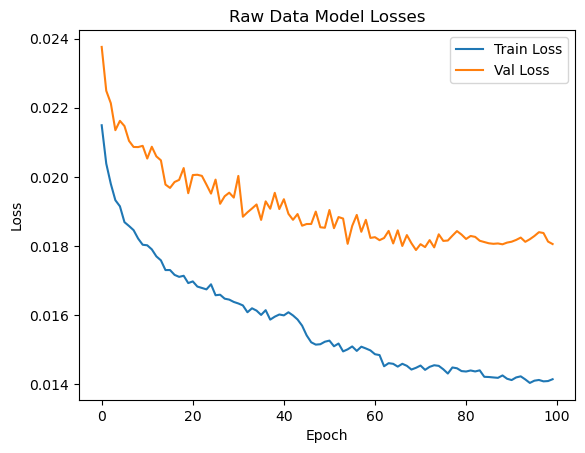

In [32]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Raw Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

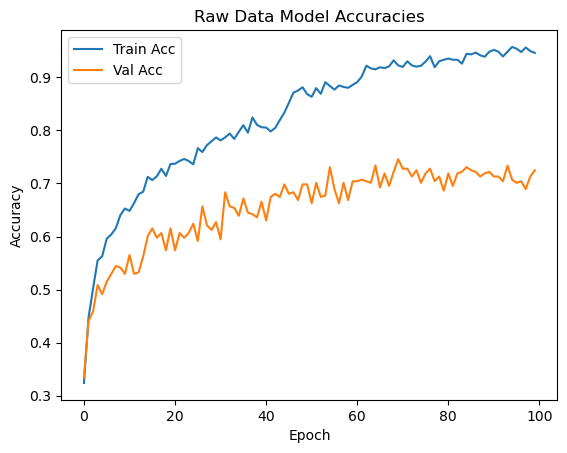

In [33]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Raw Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [34]:
# Load best model and test
raw_model = torch.load("models/cnn_rnn/raw.pt")
raw_model.to(DEVICE)
raw_model.eval()

RNNWithCNN(
  (cnn): Sequential(
    (0): Conv1d(22, 32, kernel_size=(8,), stride=(1,), padding=(4,))
    (1): ELU(alpha=1.0)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
    (5): Conv1d(32, 64, kernel_size=(10,), stride=(1,), padding=(5,))
    (6): ELU(alpha=1.0)
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.5, inplace=False)
    (10): Conv1d(64, 128, kernel_size=(12,), stride=(1,), padding=(6,))
    (11): ELU(alpha=1.0)
    (12): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.5, inplace=False)
    (15): Conv1d(128, 256, kernel_size=(14,

In [35]:
# Evaluate on raw data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[RAW]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = raw_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[RAW].dataset)
print("Train on raw data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on raw data, evaluate on raw data
Test Acc: 0.7359


In [36]:
# Evaluate on sub1 data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[SUB1]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = raw_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[SUB1].dataset)
print("Train on raw data, evaluate on sub1 data")
print(f"Test Acc: {test_acc:.4f}")

Train on raw data, evaluate on sub1 data
Test Acc: 0.6400


## Subject 1 Only    

In [37]:
sub1_model = RNNWithCNN()
sub1_model.to(DEVICE)

optimizer = torch.optim.Adam(sub1_model.parameters(), lr=0.001, weight_decay=1e-03)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=sub1_model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_func=nn.CrossEntropyLoss(),
    train_data=train_data[SUB1],
    val_data=valid_data[SUB1],
    early_stopping_patience=30,
    cp_path="models/cnn_rnn",
    cp_filename="sub1.pt",
    n_epochs=80,
    show_progress_bar=False,
)

Using device: mps
[Epoch 0] val_acc=0.263158 train_acc=0.271357 val_loss=0.036441 train_loss=0.028215
Validation loss decreased (inf --> 0.036441).  Saving model ...
[Epoch 1] val_acc=0.236842 train_acc=0.366834 val_loss=0.036349 train_loss=0.026560
Validation loss decreased (0.036441 --> 0.036349).  Saving model ...
[Epoch 2] val_acc=0.236842 train_acc=0.467337 val_loss=0.036294 train_loss=0.025775
Validation loss decreased (0.036349 --> 0.036294).  Saving model ...
[Epoch 3] val_acc=0.236842 train_acc=0.487437 val_loss=0.036294 train_loss=0.025146
EarlyStopping counter: 1 out of 30
[Epoch 4] val_acc=0.236842 train_acc=0.557789 val_loss=0.036771 train_loss=0.024127
EarlyStopping counter: 2 out of 30
[Epoch 5] val_acc=0.263158 train_acc=0.542714 val_loss=0.037522 train_loss=0.024406
EarlyStopping counter: 3 out of 30
[Epoch 6] val_acc=0.289474 train_acc=0.623116 val_loss=0.038075 train_loss=0.025292
EarlyStopping counter: 4 out of 30
[Epoch 7] val_acc=0.289474 train_acc=0.613065 val_lo

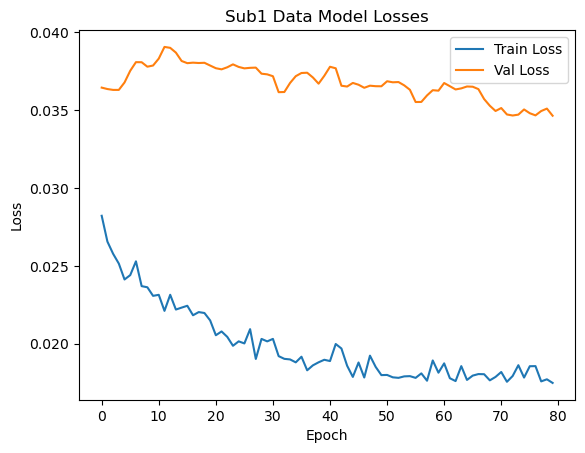

In [38]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Sub1 Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

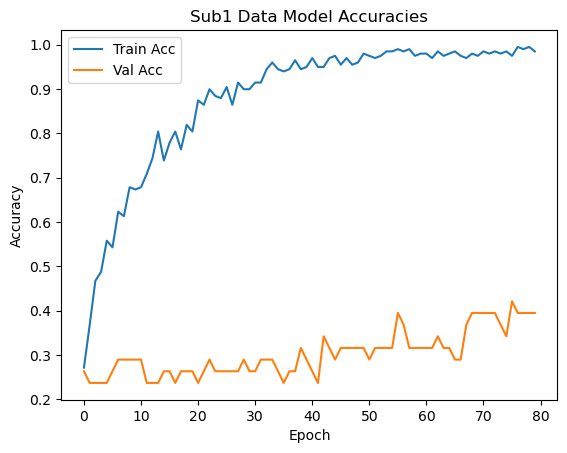

In [39]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Sub1 Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [40]:
# Load best model and test
sub1_model = torch.load("models/cnn_rnn/sub1.pt")
sub1_model.to(DEVICE)
sub1_model.eval()

RNNWithCNN(
  (cnn): Sequential(
    (0): Conv1d(22, 32, kernel_size=(8,), stride=(1,), padding=(4,))
    (1): ELU(alpha=1.0)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
    (5): Conv1d(32, 64, kernel_size=(10,), stride=(1,), padding=(5,))
    (6): ELU(alpha=1.0)
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.5, inplace=False)
    (10): Conv1d(64, 128, kernel_size=(12,), stride=(1,), padding=(6,))
    (11): ELU(alpha=1.0)
    (12): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.5, inplace=False)
    (15): Conv1d(128, 256, kernel_size=(14,

In [41]:
# Evaluate on sub1 data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[SUB1]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = sub1_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[SUB1].dataset)
print("Train on sub1 data, evaluate on sub1 data")
print(f"Test Acc: {test_acc:.4f}")

Train on sub1 data, evaluate on sub1 data
Test Acc: 0.4600


In [42]:
# Evaluate on raw data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[RAW]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = sub1_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[RAW].dataset)
print("Train on sub1 data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on sub1 data, evaluate on raw data
Test Acc: 0.3883


## Frequency Filtering Data

In [43]:
freq_model = RNNWithCNN()
freq_model.to(DEVICE)

optimizer = torch.optim.Adam(freq_model.parameters(), lr=0.001, weight_decay=1e-03)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=freq_model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_func=nn.CrossEntropyLoss(),
    train_data=train_data[FREQ],
    val_data=valid_data[RAW],
    early_stopping_patience=30,
    cp_path="models/cnn_rnn",
    cp_filename="freq.pt",
    n_epochs=100,
    show_progress_bar=False,
)

Using device: mps
[Epoch 0] val_acc=0.360947 train_acc=0.334271 val_loss=0.023763 train_loss=0.021491
Validation loss decreased (inf --> 0.023763).  Saving model ...
[Epoch 1] val_acc=0.437870 train_acc=0.425999 val_loss=0.022404 train_loss=0.020619
Validation loss decreased (0.023763 --> 0.022404).  Saving model ...
[Epoch 2] val_acc=0.473373 train_acc=0.486213 val_loss=0.022112 train_loss=0.020054
Validation loss decreased (0.022404 --> 0.022112).  Saving model ...
[Epoch 3] val_acc=0.473373 train_acc=0.522228 val_loss=0.022571 train_loss=0.019611
EarlyStopping counter: 1 out of 30
[Epoch 4] val_acc=0.514793 train_acc=0.577940 val_loss=0.021318 train_loss=0.019061
Validation loss decreased (0.022112 --> 0.021318).  Saving model ...
[Epoch 5] val_acc=0.526627 train_acc=0.594823 val_loss=0.021042 train_loss=0.018783
Validation loss decreased (0.021318 --> 0.021042).  Saving model ...
[Epoch 6] val_acc=0.579882 train_acc=0.592572 val_loss=0.020550 train_loss=0.018739
Validation loss dec

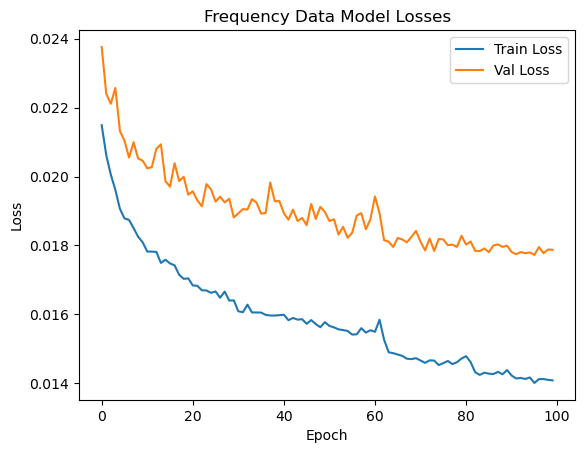

In [44]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Frequency Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

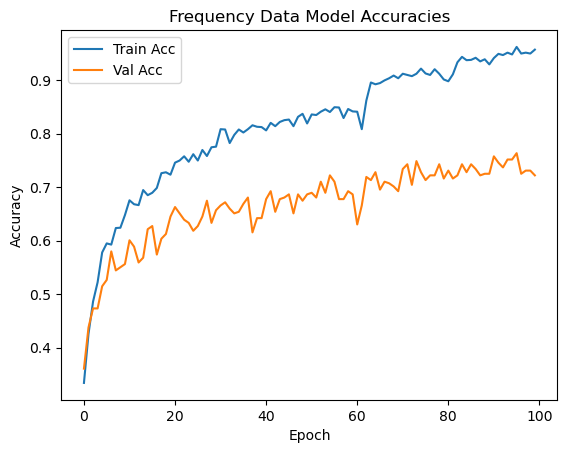

In [45]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Frequency Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [46]:
# Load best model and test
freq_model = torch.load("models/cnn_rnn/freq.pt")
freq_model.to(DEVICE)
freq_model.eval()

RNNWithCNN(
  (cnn): Sequential(
    (0): Conv1d(22, 32, kernel_size=(8,), stride=(1,), padding=(4,))
    (1): ELU(alpha=1.0)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
    (5): Conv1d(32, 64, kernel_size=(10,), stride=(1,), padding=(5,))
    (6): ELU(alpha=1.0)
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.5, inplace=False)
    (10): Conv1d(64, 128, kernel_size=(12,), stride=(1,), padding=(6,))
    (11): ELU(alpha=1.0)
    (12): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.5, inplace=False)
    (15): Conv1d(128, 256, kernel_size=(14,

In [47]:
# Evaluate on frequency data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[RAW]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = freq_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[RAW].dataset)
print("Train on frequency data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on frequency data, evaluate on raw data
Test Acc: 0.7472


## Time Series

In [51]:
time_slots = [50, 100, 150, 200, 250, 500, 750, 1000]

In [52]:
valid_acc = {}
test_acc = {}

for ts in time_slots:
    train_data, valid_data, test_data = get_time_series_dataloader(ts)
    
    time_model = RNNWithCNN(time_dim=ts)
    time_model.to(DEVICE)
    
    optimizer = torch.optim.Adam(time_model.parameters(), lr=0.001, weight_decay=1e-03)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    _ = train(
        model=time_model,
        optimizer=optimizer,
        scheduler=scheduler,
        loss_func=nn.CrossEntropyLoss(),
        train_data=train_data,
        val_data=valid_data,
        early_stopping_patience=30,
        cp_path="models/cnn_rnn",
        cp_filename=f"time_{ts}.pt",
        n_epochs=100,
        show_progress_bar=False,
    )
    
    # Load best model and test
    time_model = torch.load(f"models/cnn_rnn/time_{ts}.pt")
    time_model.to(DEVICE)
    time_model.eval()
    
    # Evaluate validation accuracies
    valid_acc[ts] = 0
    with torch.no_grad():
        for X, y in valid_data:
            X, y = X.to(DEVICE), y.to(DEVICE)
            y_pred = time_model(X)
            valid_acc[ts] += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
    valid_acc[ts] /= len(valid_data.dataset)
    
    # Evaluate test accuracies
    test_acc[ts] = 0
    with torch.no_grad():
        for X, y in test_data:
            X, y = X.to(DEVICE), y.to(DEVICE)
            y_pred = time_model(X)
            test_acc[ts] += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
    test_acc[ts] /= len(test_data.dataset)

Using device: mps
[Epoch 0] val_acc=0.322485 train_acc=0.299381 val_loss=0.024008 train_loss=0.021879
Validation loss decreased (inf --> 0.024008).  Saving model ...
[Epoch 1] val_acc=0.366864 train_acc=0.350591 val_loss=0.023760 train_loss=0.021351
Validation loss decreased (0.024008 --> 0.023760).  Saving model ...
[Epoch 2] val_acc=0.319527 train_acc=0.362409 val_loss=0.023922 train_loss=0.021251
EarlyStopping counter: 1 out of 30
[Epoch 3] val_acc=0.369822 train_acc=0.387732 val_loss=0.023354 train_loss=0.021043
Validation loss decreased (0.023760 --> 0.023354).  Saving model ...
[Epoch 4] val_acc=0.343195 train_acc=0.401238 val_loss=0.023833 train_loss=0.020955
EarlyStopping counter: 1 out of 30
[Epoch 5] val_acc=0.346154 train_acc=0.410242 val_loss=0.023649 train_loss=0.020780
EarlyStopping counter: 2 out of 30
[Epoch 6] val_acc=0.384615 train_acc=0.413056 val_loss=0.023489 train_loss=0.020784
EarlyStopping counter: 3 out of 30
[Epoch 7] val_acc=0.384615 train_acc=0.453011 val_lo

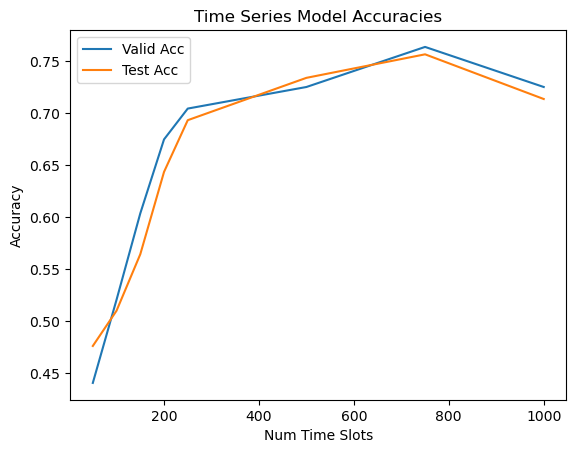

In [54]:
plt.plot(valid_acc.keys(), valid_acc.values(), label="Valid Acc")
plt.plot(test_acc.keys(), test_acc.values(), label="Test Acc")
plt.legend()
plt.title("Time Series Model Accuracies")
plt.xlabel("Num Time Slots")
plt.ylabel("Accuracy")
plt.show()